In [1]:
import os
import time
from datetime import datetime, timedelta
import ee
import geemap
import geopandas as gpd
import pandas as pd
import pandasql as sqldf
#ee.Authenticate()
#geemap.ee_search()
ee.Initialize()
Map = geemap.Map()

In [2]:
token='WaghgDFMNLfxzKTRXY2byPVfVxudO9IUc0NTqnsPZ_IvcVzjj847lwzkTpymAU212iMsc0ALecNQH_mfYEoOVG0MdTBw4pv4g_dkcqm-9Avsj8b4hCcNzToNbYsjl4jonPObD_yd0f8Xb7ZZ5IVoJH1UfLv1G_i-KrngOOLgM86YVZkcjJew8OyDwEPT4Wb7_txKl0uVitdsoeJPhr3S8ISquIHYWci1FP84KEdFyEsJmBwXQxc99FTVXZlc757b'

In [3]:
rodales_cdc='https://araucaria.arauco.com/server/rest/services/Hosted/COMPRA_DE_BOSQUE_gdb/FeatureServer/0/query?where=rol%3D+%27{rol}%27+and+comuna+%3D+%27{comuna}%27+and+especie+%3D+%27{especie}%27+and+rut_prov%3D%27{rut}%27&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=&having=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=xyFootprint&resultOffset=&resultRecordCount=&returnTrueCurves=false&returnCentroid=false&sqlFormat=none&resultType=&f=geojson&token='+token

In [4]:
# %%
ahora=time.strftime('%Y%m%d', time.localtime(time.time()))
cvol='//fileserverscl/gpd$/212_CADENA_CUSTODIA/Control_Volumen.xlsb'


In [5]:
dfcv=pd.read_excel(cvol, sheet_name='Reporte Volumen', header=7, engine='pyxlsb')
dfcv_1=dfcv[dfcv['ROL']=='140-40']
dfcv_1['pk'] = dfcv_1['ROL'].astype(str) + '_' + dfcv_1['COMUNA'] + '_' + dfcv_1['ESPECIE'] + '_' + dfcv_1['RUT PROVEEDOR'].astype(str)

In [6]:
dfcv_1

,RutProvEspecieComunaRol1Rol2GruProducto,Con_Rol,FECHA INICIO CONTRATO,ENC. GESTION COMERCIAL,RUT PROVEEDOR,PROVEEDOR,ESPECIE,PRODUCTO,ROL,NOMBRE_ORIGEN,COMUNA,VOL. TOTAL CONTRATADO,VOLUMEN REAL,VOLUMEN DIFERENCIA,% CUMPLIMIENTO,ESTADO ROL,CERTIFICACION\nFSC,CERTIFICACION\nPEFC,ULTIMA ENTREGA,pk
224,0x17,0x17,44927,ALVENIS CHAVEZ,77032386-K,SOCIEDAD AGP MADERAS SPA,EUGL,PULPABLE,140-40,CONCAVEN LAS HERAS,VICHUQUEN,7564.0,8237.92,-673.92,1.089096,CONTRATADO,MATERIAL CONTROLADO,OTROS MATERIALES,45090,140-40_VICHUQUEN_EUGL_77032386-K


In [7]:
df_analizar=dfcv_1['pk'].tolist()

In [8]:
df_analizar[0]

'140-40_VICHUQUEN_EUGL_77032386-K'

In [9]:
pk_parts = df_analizar[0].split('_')


In [10]:
rol=pk_parts[0]
comuna=pk_parts[1]
especie=pk_parts[2]
rut=pk_parts[3]

<AxesSubplot:>

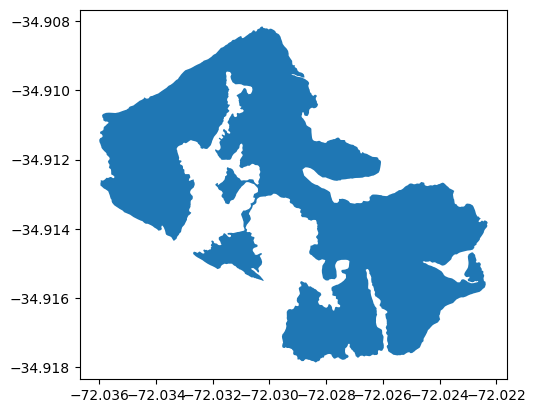

In [11]:
gdf_rd = gpd.read_file(rodales_cdc.format(rol=rol,comuna=comuna,especie=especie, rut=rut))
gdf_rd['pk']=gdf_rd['rol'] + '-'+gdf_rd['comuna']+ '-'+gdf_rd['especie']+'-'+gdf_rd['rut_prov']
gdf_rd.plot()

In [12]:
fc_rd=geemap.geopandas_to_ee(gdf_rd)
fc_rd2=fc_rd.map(lambda f: f.buffer(30))

In [13]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming dfcv_1 is your DataFrame
dfcv_1['ULTIMA ENTREGA'] = dfcv_1['ULTIMA ENTREGA'].astype(int)

base_date = datetime(1899, 12, 30)  # Excel's base date

dfcv_1['Date'] = dfcv_1['ULTIMA ENTREGA'].apply(lambda x: base_date + timedelta(days=x))
dfcv_1['Formatted Date'] = dfcv_1['Date'].dt.strftime('%Y-%m-%d')
dfcv_1['date_contrato']=dfcv_1['FECHA INICIO CONTRATO'].apply(lambda x: base_date + timedelta(days=x))
dfcv_1['dcf']=dfcv_1['date_contrato'].dt.strftime('%Y-%m-%d')

In [14]:
last_not=dfcv_1['Formatted Date'].tolist()[0]
end_date2=(datetime.strptime(last_not, '%Y-%m-%d') - timedelta(days=6*30)).strftime('%Y-%m-%d')
start_date2=dfcv_1['dcf'].tolist()[0]

In [15]:
# Define the date range
start_date = '2019-12-01'
end_date = '2019-12-01'


# end_date2=time.strftime('%Y-%m-%d', time.localtime(time.time()))
# start_date2=(datetime.strptime(last_not, '%Y-%m-%d') + timedelta(days=3*30)).strftime('%Y-%m-%d')

# Define the function to add NDVI band
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename("ndvi")
    image = image.addBands(ndvi)
    return image

st2_inicial = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate(start_date, end_date) \
    .filterBounds(fc_rd2) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .filter(ee.Filter.gte('system:asset_size', 1e9)) \
    .map(addNDVI)

st2_final = st2_inicial = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate(start_date2, end_date2) \
    .filterBounds(fc_rd2) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .filter(ee.Filter.gte('system:asset_size', 1e9)) \
    .map(addNDVI)

preharvest=st2_inicial.max()\
            .clip(fc_rd2)\
            .select('ndvi')

preharvest_mean = preharvest.reduceRegions(
    collection=fc_rd2,
    reducer=ee.Reducer.mean(),
    scale=10
)

ndvi0 = preharvest_mean.filter(ee.Filter.notNull(['mean'])).reduceToImage(
    properties=['mean'],
    reducer=ee.Reducer.first()
)

ndvi1=st2_final.min()\
            .clip(fc_rd2)\
            .select('ndvi')
min_ndvi_date = ndvi1.date().format('YYYY-MM-dd')

Dndvi=ndvi0.subtract(ndvi1)

harvest_zone = Dndvi.gte(0.1)

zones = harvest_zone.updateMask(harvest_zone.neq(0))

# Reduce to vectors
vectors = zones.reduceToVectors(
    geometry=fc_rd2,
    crs='EPSG:4326',
    scale=1,
    geometryType='polygon',
    eightConnected=True,
    labelProperty='zone',
    bestEffort=False,
    maxPixels=9e10
)

In [16]:
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [17]:
viz_ndiiReclass_vector = {'color': 'white'}
Map.centerObject(vectors)
Map.addLayer(vectors, viz_ndiiReclass_vector, 'Diferencias')


EEException: Empty date ranges not supported for the current operation.

In [ ]:
viz_ndiiReclass_vector = {'color': 'red'}
Map.addLayer(fc_rd, viz_ndiiReclass_vector, 'rodal')